In [9]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt

img = cv2.imread("D:/IIT/SOC/Assignment 3/input_images/input_0.jpg")
sigma   = 0.7
t1      = 0.05
t2      = 0.15


# It generates gaussian kernal which is to be convoluted with the grayscale image to reduce noise
# It returns gaussian kernel 
def generate_gaussian_kernel(size, sigma): 
    ### START ###
    # write value of gaussian kernel using sigma and size
    center = size // 2
    gaussian_kernel = np.zeros((size, size))
    constant = 1 / (2 * np.pi * sigma**2)
    for i in range(size):
        for j in range(size):
            x, y = i - center, j - center
            gaussian_kernel[i, j] = constant * np.exp(-(x**2 + y**2) / (2 * sigma**2))
    gaussian_kernel /= np.sum(gaussian_kernel)
    ### END ### 
    return gaussian_kernel

# This checks if there are any pixels with more intensity around it which is in it's gradient direction 
# and supress the pixels having a maxima around it
def non_maximum_suppression(G, theta):
    # Finding dimensions of the image
    N, M = G.shape
    print (f"Dimensions of the image {N}x{M}")
    # Parsing through the all pixels
    for i_x in range(M):
        for i_y in range(N):
            
            grad_ang = theta[i_y, i_x]
            grad_ang = abs(grad_ang-180) if abs(grad_ang)>180 else abs(grad_ang)
            
            # selecting the neighbours of the target pixel
            # according to the gradient direction
            # In the x axis direction
            if grad_ang<= 22.5:
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y
            
            # top right (diagonal-1) direction
            elif grad_ang>22.5 and grad_ang<=(22.5 + 45):
                ### START ###
                # SEE grad_ang<=22.5 case and fill accordingly
                neighb_1_x, neighb_1_y = i_x - 1, i_y - 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y + 1
                ### END ###

            # In y-axis direction
            elif grad_ang>(22.5 + 45) and grad_ang<=(22.5 + 90):
                ### START ###
                # SEE grad_ang<=22.5 case and fill accordingly
                neighb_1_x, neighb_1_y = i_x, i_y - 1
                neighb_2_x, neighb_2_y = i_x, i_y + 1
                ### END ###

            # top left (diagonal-2) direction
            elif grad_ang>(22.5 + 90) and grad_ang<=(22.5 + 135):
                ### START ###
                # SEE grad_ang<=22.5 case and fill accordingly
                neighb_1_x, neighb_1_y = i_x + 1, i_y - 1
                neighb_2_x, neighb_2_y = i_x - 1, i_y + 1
                ### END ###

            # Now it restarts the cycle
            elif grad_ang>(22.5 + 135) and grad_ang<=(22.5 + 180):
                ### START ###
                # SEE grad_ang<=22.5 case and fill accordingly
                neighb_1_x, neighb_1_y = i_x - 1, i_y 
                neighb_2_x, neighb_2_y = i_x + 1, i_y
                ### END ###

            # Non-maximum suppression step
            if M>neighb_1_x>= 0 and N>neighb_1_y>= 0:
                if  G[i_y, i_x]< G[neighb_1_y, neighb_1_x]:
                    G[i_y, i_x]= 0
                    continue

            if M>neighb_2_x>= 0 and N>neighb_2_y>= 0:
                if  G[i_y, i_x]< G[neighb_2_y, neighb_2_x]:
                    G[i_y, i_x]= 0

    return G

# Perform hysteresis thresholding to determine strong and weak edges.
def hysteresis_thresholding(img, t1, t2):
    
    weak = np.zeros_like(img)
    strong = np.zeros_like(img)
    strong_threshold = np.max(img) * t2
    weak_threshold = np.max(img) * t1

    strong[img >= strong_threshold] = 255
    weak[(img >= weak_threshold) & (img < strong_threshold)] = 128

    # perform connectivity analysis to determine strong edges
    M, N = img.shape
    edge_map = np.uint8(strong)
    for i in range(1, M-1):
        for j in range(1, N-1):
            if weak[i,j] == 128:
                if (strong[i-1:i+2, j-1:j+2] == 255).any():
                    edge_map[i,j] = 255
                else:
                    edge_map[i,j] = 0

    return edge_map

# It applies convolution to the given image and the kernel matrix
def apply_convolution(img, kernel):
    M, N = img.shape
    m, n = kernel.shape
    ### START ###
    output = np.zeros((M, N))
    center = m // 2

    for i in range(center, M - center):
        for j in range(center, N - center):
            output[i, j] = np.sum(img[i - center:i + center + 1, j - center:j + center + 1] * kernel)
    ### END ###
    return output

# Finds the gradient by using sobel operators
def sobel_op(img):
    dx_kernel = np.array([[-1, 0, 1],
                          [-2, 0, 2],
                          [-1, 0, 1]], dtype=np.float32)

    dy_kernel = np.array([[-1, -2, -1],
                          [0, 0, 0],
                          [1, 2, 1]], dtype=np.float32)

    dx = np.zeros_like(img, dtype=np.float32)
    dy = np.zeros_like(img, dtype=np.float32)

    height, width = img.shape

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            ### START ###
            dx[i, j] = np.sum(img[i - 1:i + 2, j - 1:j + 2] * dx_kernel)
            dy[i, j] = np.sum(img[i - 1:i + 2, j - 1:j + 2] * dy_kernel)
            ### END ###
            
    return dx, dy

# Final canny detector function
def Canny_detector(img, sigma, t1, t2):
    # Step 1: Convert given image to grayscale image
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img_gray
    
    # Step 2: Apply Gaussian filter to smooth the image
    kernel_size = int(2 * round(3 * sigma) + 1)
    gaussian_kernel = generate_gaussian_kernel(kernel_size, sigma)   
    img_smooth = apply_convolution(img, gaussian_kernel)
    smooth_img = img_smooth
    
    # Step 3: Compute gradient  Gnitude and direction using Sobel operators
    gx, gy = sobel_op(img)
    G_mag, G_dir = cv2.cartToPolar(gx, gy, angleInDegrees = True)

    # Step 4: Perform non-maximum suppression to thin the edges
    G_suppressed = non_maximum_suppression(G_mag, G_dir)

    # Step 5: Perform hysteresis thresholding to detect strong and weak edges
    edge_image= hysteresis_thresholding(G_suppressed, t1, t2)

	# returns grayscale image , smoothened image, edge image
    return img_gray, smooth_img, edge_image


img_gray, img_smooth, img_op = Canny_detector(img, sigma, t1, t2)
cv2.imwrite("D:/IIT/SOC/Assignment 3/output_images_0/img_gray_0.jpeg", img_gray)
cv2.imwrite("D:/IIT/SOC/Assignment 3/output_images_0/img_smooth_0.jpeg", img_smooth)
cv2.imwrite("D:/IIT/SOC/Assignment 3/output_images_0/img_op_0.jpeg", img_op)

Dimensions of the image 600x600


True

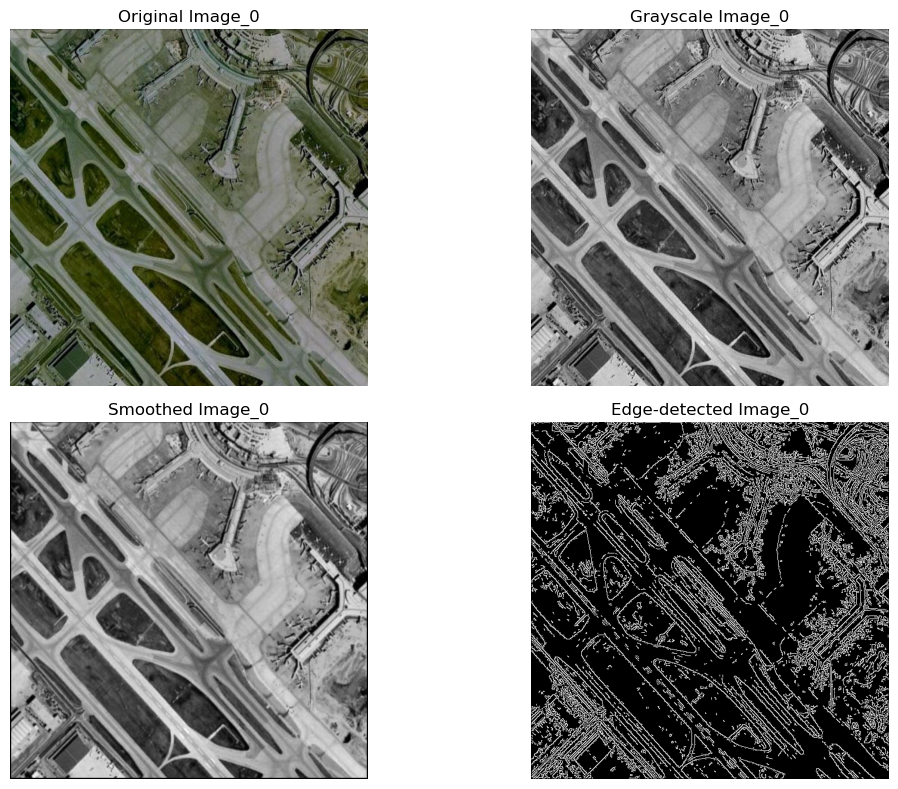

In [10]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image_0')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(img_gray, cmap='gray')
plt.title('Grayscale Image_0')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(img_smooth, cmap='gray')
plt.title('Smoothed Image_0')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(img_op, cmap='gray')
plt.title('Edge-detected Image_0')
plt.axis('off')

plt.tight_layout()
plt.show()


In [11]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt

img = cv2.imread("D:/IIT/SOC/Assignment 3/input_images/input_1.jpg")
sigma   = 0.7
t1      = 0.05
t2      = 0.15


# It generates gaussian kernal which is to be convoluted with the grayscale image to reduce noise
# It returns gaussian kernel 
def generate_gaussian_kernel(size, sigma): 
    ### START ###
    # write value of gaussian kernel using sigma and size
    center = size // 2
    gaussian_kernel = np.zeros((size, size))
    constant = 1 / (2 * np.pi * sigma**2)
    for i in range(size):
        for j in range(size):
            x, y = i - center, j - center
            gaussian_kernel[i, j] = constant * np.exp(-(x**2 + y**2) / (2 * sigma**2))
    gaussian_kernel /= np.sum(gaussian_kernel)
    ### END ### 
    return gaussian_kernel

# This checks if there are any pixels with more intensity around it which is in it's gradient direction 
# and supress the pixels having a maxima around it
def non_maximum_suppression(G, theta):
    # Finding dimensions of the image
    N, M = G.shape
    print (f"Dimensions of the image {N}x{M}")
    # Parsing through the all pixels
    for i_x in range(M):
        for i_y in range(N):
            
            grad_ang = theta[i_y, i_x]
            grad_ang = abs(grad_ang-180) if abs(grad_ang)>180 else abs(grad_ang)
            
            # selecting the neighbours of the target pixel
            # according to the gradient direction
            # In the x axis direction
            if grad_ang<= 22.5:
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y
            
            # top right (diagonal-1) direction
            elif grad_ang>22.5 and grad_ang<=(22.5 + 45):
                ### START ###
                # SEE grad_ang<=22.5 case and fill accordingly
                neighb_1_x, neighb_1_y = i_x - 1, i_y - 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y + 1
                ### END ###

            # In y-axis direction
            elif grad_ang>(22.5 + 45) and grad_ang<=(22.5 + 90):
                ### START ###
                # SEE grad_ang<=22.5 case and fill accordingly
                neighb_1_x, neighb_1_y = i_x, i_y - 1
                neighb_2_x, neighb_2_y = i_x, i_y + 1
                ### END ###

            # top left (diagonal-2) direction
            elif grad_ang>(22.5 + 90) and grad_ang<=(22.5 + 135):
                ### START ###
                # SEE grad_ang<=22.5 case and fill accordingly
                neighb_1_x, neighb_1_y = i_x + 1, i_y - 1
                neighb_2_x, neighb_2_y = i_x - 1, i_y + 1
                ### END ###

            # Now it restarts the cycle
            elif grad_ang>(22.5 + 135) and grad_ang<=(22.5 + 180):
                ### START ###
                # SEE grad_ang<=22.5 case and fill accordingly
                neighb_1_x, neighb_1_y = i_x - 1, i_y 
                neighb_2_x, neighb_2_y = i_x + 1, i_y
                ### END ###

            # Non-maximum suppression step
            if M>neighb_1_x>= 0 and N>neighb_1_y>= 0:
                if  G[i_y, i_x]< G[neighb_1_y, neighb_1_x]:
                    G[i_y, i_x]= 0
                    continue

            if M>neighb_2_x>= 0 and N>neighb_2_y>= 0:
                if  G[i_y, i_x]< G[neighb_2_y, neighb_2_x]:
                    G[i_y, i_x]= 0

    return G

# Perform hysteresis thresholding to determine strong and weak edges.
def hysteresis_thresholding(img, t1, t2):
    
    weak = np.zeros_like(img)
    strong = np.zeros_like(img)
    strong_threshold = np.max(img) * t2
    weak_threshold = np.max(img) * t1

    strong[img >= strong_threshold] = 255
    weak[(img >= weak_threshold) & (img < strong_threshold)] = 128

    # perform connectivity analysis to determine strong edges
    M, N = img.shape
    edge_map = np.uint8(strong)
    for i in range(1, M-1):
        for j in range(1, N-1):
            if weak[i,j] == 128:
                if (strong[i-1:i+2, j-1:j+2] == 255).any():
                    edge_map[i,j] = 255
                else:
                    edge_map[i,j] = 0

    return edge_map

# It applies convolution to the given image and the kernel matrix
def apply_convolution(img, kernel):
    M, N = img.shape
    m, n = kernel.shape
    ### START ###
    output = np.zeros((M, N))
    center = m // 2

    for i in range(center, M - center):
        for j in range(center, N - center):
            output[i, j] = np.sum(img[i - center:i + center + 1, j - center:j + center + 1] * kernel)
    ### END ###
    return output

# Finds the gradient by using sobel operators
def sobel_op(img):
    dx_kernel = np.array([[-1, 0, 1],
                          [-2, 0, 2],
                          [-1, 0, 1]], dtype=np.float32)

    dy_kernel = np.array([[-1, -2, -1],
                          [0, 0, 0],
                          [1, 2, 1]], dtype=np.float32)

    dx = np.zeros_like(img, dtype=np.float32)
    dy = np.zeros_like(img, dtype=np.float32)

    height, width = img.shape

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            ### START ###
            dx[i, j] = np.sum(img[i - 1:i + 2, j - 1:j + 2] * dx_kernel)
            dy[i, j] = np.sum(img[i - 1:i + 2, j - 1:j + 2] * dy_kernel)
            ### END ###
            
    return dx, dy

# Final canny detector function
def Canny_detector(img, sigma, t1, t2):
    # Step 1: Convert given image to grayscale image
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img_gray
    
    # Step 2: Apply Gaussian filter to smooth the image
    kernel_size = int(2 * round(3 * sigma) + 1)
    gaussian_kernel = generate_gaussian_kernel(kernel_size, sigma)   
    img_smooth = apply_convolution(img, gaussian_kernel)
    smooth_img = img_smooth
    
    # Step 3: Compute gradient  Gnitude and direction using Sobel operators
    gx, gy = sobel_op(img)
    G_mag, G_dir = cv2.cartToPolar(gx, gy, angleInDegrees = True)

    # Step 4: Perform non-maximum suppression to thin the edges
    G_suppressed = non_maximum_suppression(G_mag, G_dir)

    # Step 5: Perform hysteresis thresholding to detect strong and weak edges
    edge_image= hysteresis_thresholding(G_suppressed, t1, t2)

	# returns grayscale image , smoothened image, edge image
    return img_gray, smooth_img, edge_image


img_gray, img_smooth, img_op = Canny_detector(img, sigma, t1, t2)
cv2.imwrite("D:/IIT/SOC/Assignment 3/output_images_1/img_gray_1.jpeg", img_gray)
cv2.imwrite("D:/IIT/SOC/Assignment 3/output_images_1/img_smooth_1.jpeg", img_smooth)
cv2.imwrite("D:/IIT/SOC/Assignment 3/output_images_1/img_op_1.jpeg", img_op)

Dimensions of the image 900x948


True

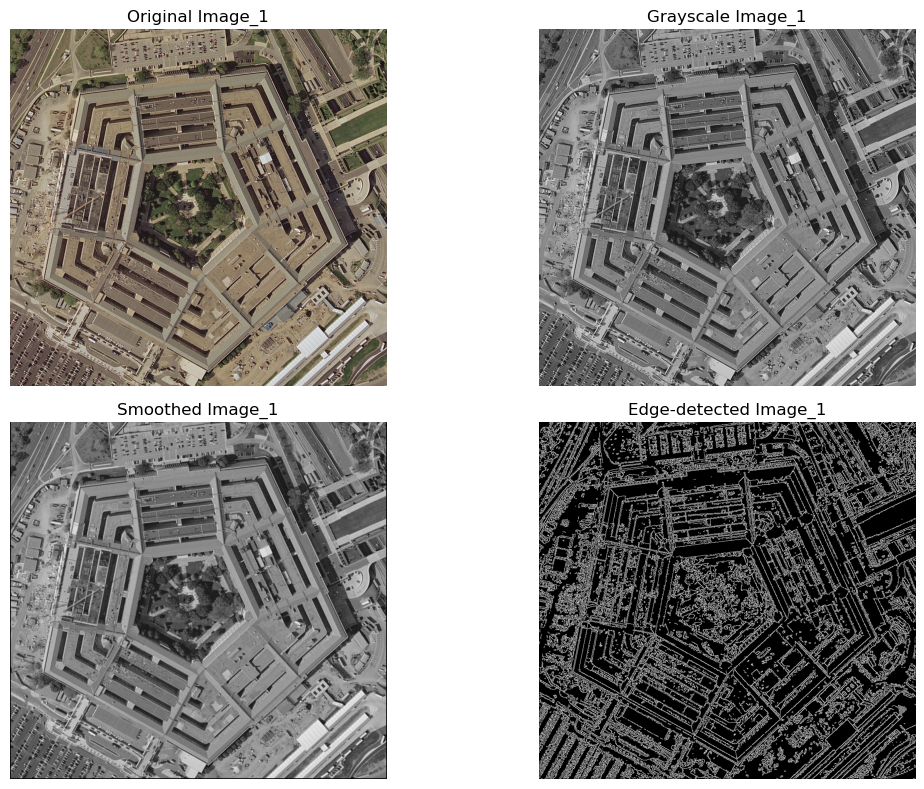

In [12]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image_1')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(img_gray, cmap='gray')
plt.title('Grayscale Image_1')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(img_smooth, cmap='gray')
plt.title('Smoothed Image_1')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(img_op, cmap='gray')
plt.title('Edge-detected Image_1')
plt.axis('off')

plt.tight_layout()
plt.show()


In [13]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt

img = cv2.imread("D:/IIT/SOC/Assignment 3/input_images/input_2.jpg")
sigma   = 0.7
t1      = 0.05
t2      = 0.15


# It generates gaussian kernal which is to be convoluted with the grayscale image to reduce noise
# It returns gaussian kernel 
def generate_gaussian_kernel(size, sigma): 
    ### START ###
    # write value of gaussian kernel using sigma and size
    center = size // 2
    gaussian_kernel = np.zeros((size, size))
    constant = 1 / (2 * np.pi * sigma**2)
    for i in range(size):
        for j in range(size):
            x, y = i - center, j - center
            gaussian_kernel[i, j] = constant * np.exp(-(x**2 + y**2) / (2 * sigma**2))
    gaussian_kernel /= np.sum(gaussian_kernel)
    ### END ### 
    return gaussian_kernel

# This checks if there are any pixels with more intensity around it which is in it's gradient direction 
# and supress the pixels having a maxima around it
def non_maximum_suppression(G, theta):
    # Finding dimensions of the image
    N, M = G.shape
    print (f"Dimensions of the image {N}x{M}")
    # Parsing through the all pixels
    for i_x in range(M):
        for i_y in range(N):
            
            grad_ang = theta[i_y, i_x]
            grad_ang = abs(grad_ang-180) if abs(grad_ang)>180 else abs(grad_ang)
            
            # selecting the neighbours of the target pixel
            # according to the gradient direction
            # In the x axis direction
            if grad_ang<= 22.5:
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y
            
            # top right (diagonal-1) direction
            elif grad_ang>22.5 and grad_ang<=(22.5 + 45):
                ### START ###
                # SEE grad_ang<=22.5 case and fill accordingly
                neighb_1_x, neighb_1_y = i_x - 1, i_y - 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y + 1
                ### END ###

            # In y-axis direction
            elif grad_ang>(22.5 + 45) and grad_ang<=(22.5 + 90):
                ### START ###
                # SEE grad_ang<=22.5 case and fill accordingly
                neighb_1_x, neighb_1_y = i_x, i_y - 1
                neighb_2_x, neighb_2_y = i_x, i_y + 1
                ### END ###

            # top left (diagonal-2) direction
            elif grad_ang>(22.5 + 90) and grad_ang<=(22.5 + 135):
                ### START ###
                # SEE grad_ang<=22.5 case and fill accordingly
                neighb_1_x, neighb_1_y = i_x + 1, i_y - 1
                neighb_2_x, neighb_2_y = i_x - 1, i_y + 1
                ### END ###

            # Now it restarts the cycle
            elif grad_ang>(22.5 + 135) and grad_ang<=(22.5 + 180):
                ### START ###
                # SEE grad_ang<=22.5 case and fill accordingly
                neighb_1_x, neighb_1_y = i_x - 1, i_y 
                neighb_2_x, neighb_2_y = i_x + 1, i_y
                ### END ###

            # Non-maximum suppression step
            if M>neighb_1_x>= 0 and N>neighb_1_y>= 0:
                if  G[i_y, i_x]< G[neighb_1_y, neighb_1_x]:
                    G[i_y, i_x]= 0
                    continue

            if M>neighb_2_x>= 0 and N>neighb_2_y>= 0:
                if  G[i_y, i_x]< G[neighb_2_y, neighb_2_x]:
                    G[i_y, i_x]= 0

    return G

# Perform hysteresis thresholding to determine strong and weak edges.
def hysteresis_thresholding(img, t1, t2):
    
    weak = np.zeros_like(img)
    strong = np.zeros_like(img)
    strong_threshold = np.max(img) * t2
    weak_threshold = np.max(img) * t1

    strong[img >= strong_threshold] = 255
    weak[(img >= weak_threshold) & (img < strong_threshold)] = 128

    # perform connectivity analysis to determine strong edges
    M, N = img.shape
    edge_map = np.uint8(strong)
    for i in range(1, M-1):
        for j in range(1, N-1):
            if weak[i,j] == 128:
                if (strong[i-1:i+2, j-1:j+2] == 255).any():
                    edge_map[i,j] = 255
                else:
                    edge_map[i,j] = 0

    return edge_map

# It applies convolution to the given image and the kernel matrix
def apply_convolution(img, kernel):
    M, N = img.shape
    m, n = kernel.shape
    ### START ###
    output = np.zeros((M, N))
    center = m // 2

    for i in range(center, M - center):
        for j in range(center, N - center):
            output[i, j] = np.sum(img[i - center:i + center + 1, j - center:j + center + 1] * kernel)
    ### END ###
    return output

# Finds the gradient by using sobel operators
def sobel_op(img):
    dx_kernel = np.array([[-1, 0, 1],
                          [-2, 0, 2],
                          [-1, 0, 1]], dtype=np.float32)

    dy_kernel = np.array([[-1, -2, -1],
                          [0, 0, 0],
                          [1, 2, 1]], dtype=np.float32)

    dx = np.zeros_like(img, dtype=np.float32)
    dy = np.zeros_like(img, dtype=np.float32)

    height, width = img.shape

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            ### START ###
            dx[i, j] = np.sum(img[i - 1:i + 2, j - 1:j + 2] * dx_kernel)
            dy[i, j] = np.sum(img[i - 1:i + 2, j - 1:j + 2] * dy_kernel)
            ### END ###
            
    return dx, dy

# Final canny detector function
def Canny_detector(img, sigma, t1, t2):
    # Step 1: Convert given image to grayscale image
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img_gray
    
    # Step 2: Apply Gaussian filter to smooth the image
    kernel_size = int(2 * round(3 * sigma) + 1)
    gaussian_kernel = generate_gaussian_kernel(kernel_size, sigma)   
    img_smooth = apply_convolution(img, gaussian_kernel)
    smooth_img = img_smooth
    
    # Step 3: Compute gradient  Gnitude and direction using Sobel operators
    gx, gy = sobel_op(img)
    G_mag, G_dir = cv2.cartToPolar(gx, gy, angleInDegrees = True)

    # Step 4: Perform non-maximum suppression to thin the edges
    G_suppressed = non_maximum_suppression(G_mag, G_dir)

    # Step 5: Perform hysteresis thresholding to detect strong and weak edges
    edge_image= hysteresis_thresholding(G_suppressed, t1, t2)

	# returns grayscale image , smoothened image, edge image
    return img_gray, smooth_img, edge_image


img_gray, img_smooth, img_op = Canny_detector(img, sigma, t1, t2)
cv2.imwrite("D:/IIT/SOC/Assignment 3/output_images_2/img_gray_2.jpeg", img_gray)
cv2.imwrite("D:/IIT/SOC/Assignment 3/output_images_2/img_smooth_2.jpeg", img_smooth)
cv2.imwrite("D:/IIT/SOC/Assignment 3/output_images_2/img_op_2.jpeg", img_op)

Dimensions of the image 600x600


True

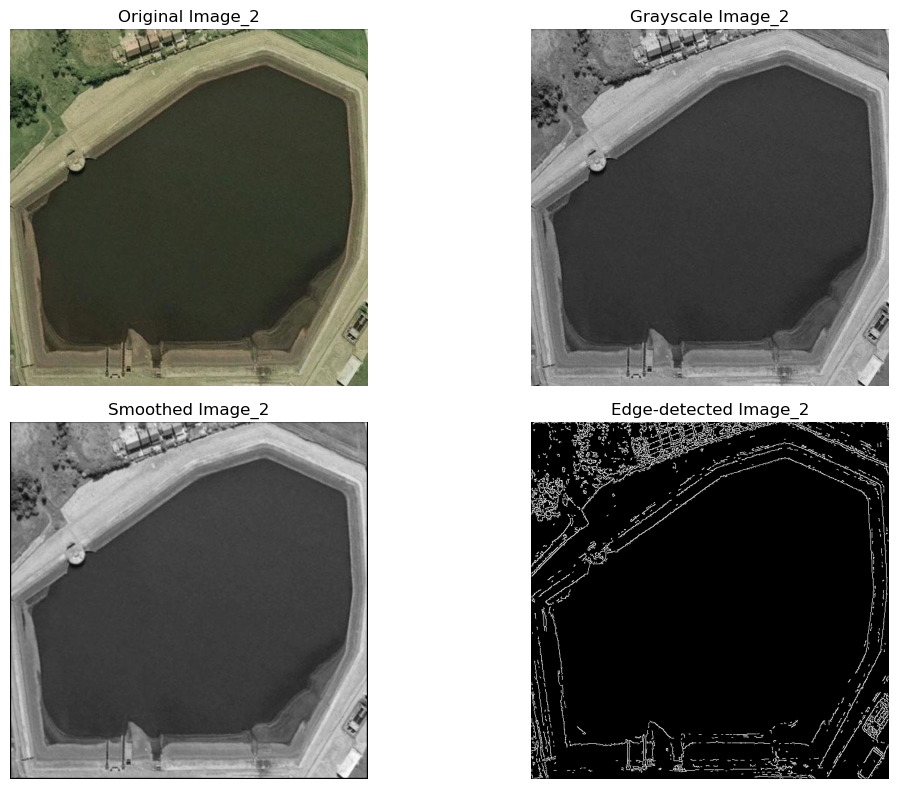

In [14]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image_2')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(img_gray, cmap='gray')
plt.title('Grayscale Image_2')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(img_smooth, cmap='gray')
plt.title('Smoothed Image_2')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(img_op, cmap='gray')
plt.title('Edge-detected Image_2')
plt.axis('off')

plt.tight_layout()
plt.show()


In [15]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt

img = cv2.imread("D:/IIT/SOC/Assignment 3/input_images/input_3.jpg")
sigma   = 0.7
t1      = 0.05
t2      = 0.15


# It generates gaussian kernal which is to be convoluted with the grayscale image to reduce noise
# It returns gaussian kernel 
def generate_gaussian_kernel(size, sigma): 
    ### START ###
    # write value of gaussian kernel using sigma and size
    center = size // 2
    gaussian_kernel = np.zeros((size, size))
    constant = 1 / (2 * np.pi * sigma**2)
    for i in range(size):
        for j in range(size):
            x, y = i - center, j - center
            gaussian_kernel[i, j] = constant * np.exp(-(x**2 + y**2) / (2 * sigma**2))
    gaussian_kernel /= np.sum(gaussian_kernel)
    ### END ### 
    return gaussian_kernel

# This checks if there are any pixels with more intensity around it which is in it's gradient direction 
# and supress the pixels having a maxima around it
def non_maximum_suppression(G, theta):
    # Finding dimensions of the image
    N, M = G.shape
    print (f"Dimensions of the image {N}x{M}")
    # Parsing through the all pixels
    for i_x in range(M):
        for i_y in range(N):
            
            grad_ang = theta[i_y, i_x]
            grad_ang = abs(grad_ang-180) if abs(grad_ang)>180 else abs(grad_ang)
            
            # selecting the neighbours of the target pixel
            # according to the gradient direction
            # In the x axis direction
            if grad_ang<= 22.5:
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y
            
            # top right (diagonal-1) direction
            elif grad_ang>22.5 and grad_ang<=(22.5 + 45):
                ### START ###
                # SEE grad_ang<=22.5 case and fill accordingly
                neighb_1_x, neighb_1_y = i_x - 1, i_y - 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y + 1
                ### END ###

            # In y-axis direction
            elif grad_ang>(22.5 + 45) and grad_ang<=(22.5 + 90):
                ### START ###
                # SEE grad_ang<=22.5 case and fill accordingly
                neighb_1_x, neighb_1_y = i_x, i_y - 1
                neighb_2_x, neighb_2_y = i_x, i_y + 1
                ### END ###

            # top left (diagonal-2) direction
            elif grad_ang>(22.5 + 90) and grad_ang<=(22.5 + 135):
                ### START ###
                # SEE grad_ang<=22.5 case and fill accordingly
                neighb_1_x, neighb_1_y = i_x + 1, i_y - 1
                neighb_2_x, neighb_2_y = i_x - 1, i_y + 1
                ### END ###

            # Now it restarts the cycle
            elif grad_ang>(22.5 + 135) and grad_ang<=(22.5 + 180):
                ### START ###
                # SEE grad_ang<=22.5 case and fill accordingly
                neighb_1_x, neighb_1_y = i_x - 1, i_y 
                neighb_2_x, neighb_2_y = i_x + 1, i_y
                ### END ###

            # Non-maximum suppression step
            if M>neighb_1_x>= 0 and N>neighb_1_y>= 0:
                if  G[i_y, i_x]< G[neighb_1_y, neighb_1_x]:
                    G[i_y, i_x]= 0
                    continue

            if M>neighb_2_x>= 0 and N>neighb_2_y>= 0:
                if  G[i_y, i_x]< G[neighb_2_y, neighb_2_x]:
                    G[i_y, i_x]= 0

    return G

# Perform hysteresis thresholding to determine strong and weak edges.
def hysteresis_thresholding(img, t1, t2):
    
    weak = np.zeros_like(img)
    strong = np.zeros_like(img)
    strong_threshold = np.max(img) * t2
    weak_threshold = np.max(img) * t1

    strong[img >= strong_threshold] = 255
    weak[(img >= weak_threshold) & (img < strong_threshold)] = 128

    # perform connectivity analysis to determine strong edges
    M, N = img.shape
    edge_map = np.uint8(strong)
    for i in range(1, M-1):
        for j in range(1, N-1):
            if weak[i,j] == 128:
                if (strong[i-1:i+2, j-1:j+2] == 255).any():
                    edge_map[i,j] = 255
                else:
                    edge_map[i,j] = 0

    return edge_map

# It applies convolution to the given image and the kernel matrix
def apply_convolution(img, kernel):
    M, N = img.shape
    m, n = kernel.shape
    ### START ###
    output = np.zeros((M, N))
    center = m // 2

    for i in range(center, M - center):
        for j in range(center, N - center):
            output[i, j] = np.sum(img[i - center:i + center + 1, j - center:j + center + 1] * kernel)
    ### END ###
    return output

# Finds the gradient by using sobel operators
def sobel_op(img):
    dx_kernel = np.array([[-1, 0, 1],
                          [-2, 0, 2],
                          [-1, 0, 1]], dtype=np.float32)

    dy_kernel = np.array([[-1, -2, -1],
                          [0, 0, 0],
                          [1, 2, 1]], dtype=np.float32)

    dx = np.zeros_like(img, dtype=np.float32)
    dy = np.zeros_like(img, dtype=np.float32)

    height, width = img.shape

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            ### START ###
            dx[i, j] = np.sum(img[i - 1:i + 2, j - 1:j + 2] * dx_kernel)
            dy[i, j] = np.sum(img[i - 1:i + 2, j - 1:j + 2] * dy_kernel)
            ### END ###
            
    return dx, dy

# Final canny detector function
def Canny_detector(img, sigma, t1, t2):
    # Step 1: Convert given image to grayscale image
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img_gray
    
    # Step 2: Apply Gaussian filter to smooth the image
    kernel_size = int(2 * round(3 * sigma) + 1)
    gaussian_kernel = generate_gaussian_kernel(kernel_size, sigma)   
    img_smooth = apply_convolution(img, gaussian_kernel)
    smooth_img = img_smooth
    
    # Step 3: Compute gradient  Gnitude and direction using Sobel operators
    gx, gy = sobel_op(img)
    G_mag, G_dir = cv2.cartToPolar(gx, gy, angleInDegrees = True)

    # Step 4: Perform non-maximum suppression to thin the edges
    G_suppressed = non_maximum_suppression(G_mag, G_dir)

    # Step 5: Perform hysteresis thresholding to detect strong and weak edges
    edge_image= hysteresis_thresholding(G_suppressed, t1, t2)

	# returns grayscale image , smoothened image, edge image
    return img_gray, smooth_img, edge_image


img_gray, img_smooth, img_op = Canny_detector(img, sigma, t1, t2)
cv2.imwrite("D:/IIT/SOC/Assignment 3/output_images_3/img_gray_3.jpeg", img_gray)
cv2.imwrite("D:/IIT/SOC/Assignment 3/output_images_3/img_smooth_3.jpeg", img_smooth)
cv2.imwrite("D:/IIT/SOC/Assignment 3/output_images_3/img_op_3.jpeg", img_op)

Dimensions of the image 600x600


True

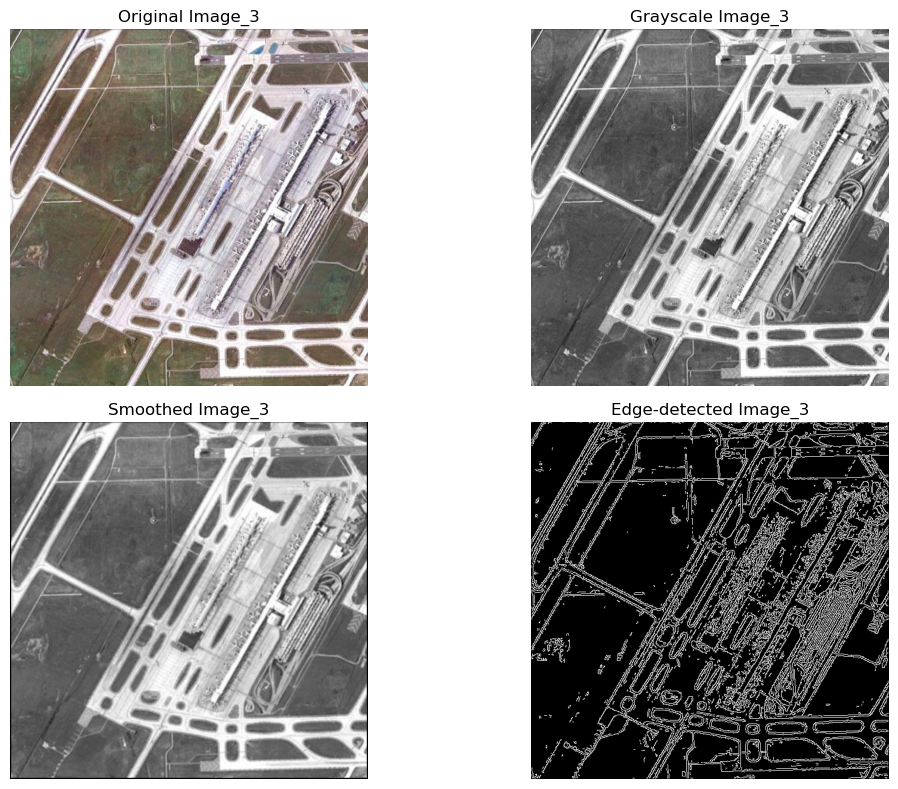

In [16]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image_3')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(img_gray, cmap='gray')
plt.title('Grayscale Image_3')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(img_smooth, cmap='gray')
plt.title('Smoothed Image_3')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(img_op, cmap='gray')
plt.title('Edge-detected Image_3')
plt.axis('off')

plt.tight_layout()
plt.show()
